In [1]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# For pretty plots
sns.set(style='whitegrid')


In [2]:
# Load your raw or feature-engineered test data file
test_df = pd.read_csv('../data/CMAPSSData/test_FD001.txt', sep='\\s+', header=None, index_col=None)
# Update column names as appropriate for your dataset
col_names = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
test_df.columns = col_names

# Preview top rows
display(test_df.head())


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [3]:
# Number of engines and cycles overview
print(f'Unique engines/units: {test_df["unit"].nunique()}')
print(f'Total cycles/rows: {len(test_df)}')
print('Cycle count (by engine):')
display(test_df.groupby('unit')['cycle'].max().describe())


Unique engines/units: 100
Total cycles/rows: 13096
Cycle count (by engine):


count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: cycle, dtype: float64

#### Feature Engineering for RUL Prediction

In [4]:
# Example: Add rolling means for a few key sensors
for s in ['sensor_4', 'sensor_7', 'sensor_12', 'sensor_21']:
    test_df[f'{s}_rollmean'] = (
        test_df.groupby('unit')[s].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
    )

# Example: Add rolling slope for a sensor
def rolling_slope(x, window=5):
    idx = np.arange(len(x))
    return x.rolling(window, min_periods=2).apply(lambda y: np.polyfit(np.arange(len(y)), y, 1)[0], raw=True)

for s in ['sensor_12', 'sensor_7', 'sensor_21']:
    test_df[f'{s}_slope'] = test_df.groupby('unit')[s].apply(rolling_slope).reset_index(level=0, drop=True)

# Drop unnecessary columns for demonstration
drop_cols = ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
test_df = test_df.drop(columns=drop_cols)
display(test_df.head())


,unit,cycle,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,...,sensor_17,sensor_20,sensor_21,sensor_4_rollmean,sensor_7_rollmean,sensor_12_rollmean,sensor_21_rollmean,sensor_12_slope,sensor_7_slope,sensor_21_slope
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,...,392,38.86,23.3735,1398.210000,553.900000,521.7200,23.37350,NaN,NaN,NaN
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,...,393,39.02,23.3916,1396.815000,554.375000,521.9400,23.38255,0.440,0.950,0.01810
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,...,393,39.08,23.4166,1398.323333,554.286667,521.9500,23.39390,0.125,0.105,0.02155
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,...,391,39.00,23.3737,1400.347500,554.232500,521.8075,23.38885,-0.121,-0.023,0.00256
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,...,390,38.99,23.4130,1400.662000,554.218000,521.8760,23.39368,0.008,-0.026,0.00611


#### Prepare a Test Sequence and Call the API

In [5]:
# Helper function to get the most recent sequence for one unit
SEQUENCE_LENGTH = 30
feature_names = [
    'op_setting_1', 'op_setting_2',
    'sensor_4_rollmean', 'sensor_12', 'sensor_7', 'sensor_21', 'sensor_20',
    'sensor_12_rollmean', 'sensor_7_rollmean', 'sensor_21_rollmean',
    'sensor_12_slope', 'sensor_7_slope', 'sensor_21_slope'
]

def get_api_sequence(df, unit_id):
    seq_df = df[df['unit']==unit_id].tail(SEQUENCE_LENGTH)
    # Make sure enough data is available
    if len(seq_df) < SEQUENCE_LENGTH:
        return None
    return [
        {f: float(seq_df.iloc[i][f]) for f in feature_names}
        for i in range(SEQUENCE_LENGTH)
    ]

# Select a random unit for demonstration
unit_id = test_df['unit'].sample(1).iloc[0]
sample_sequence = get_api_sequence(test_df, unit_id)
print(f"Unit ID: {unit_id}, Sequence Length: {len(sample_sequence) if sample_sequence else 0}")

# Call your API (must be running locally on port 8000)
if sample_sequence:
    payload = {"sequence": sample_sequence}
    response = requests.post('http://localhost:8000/predict_rul', json=payload)
    print("Predicted RUL:", response.json())  # Returns {'predicted_RUL': ...}


Unit ID: 12, Sequence Length: 30
Predicted RUL: {'predicted_RUL': 128.21078491210938}


#### Visualize True vs. Predicted RUL for Multiple Units

In [6]:
# Load true RULs for FD001 test set
true_rul_df = pd.read_csv('../data/CMAPSSData/RUL_FD001.txt', sep='\\s+', names=['true_RUL'])

rul_preds = []
true_ruls = []
units = []

for idx, unit in enumerate(test_df['unit'].unique()):
    seq = get_api_sequence(test_df, unit)
    if not seq:
        continue

    payload = {"sequence": seq}
    response = requests.post("http://localhost:8000/predict_rul", json=payload)
    pred_rul = response.json()["predicted_RUL"]

    # Ground truth from file (aligning by unit index)
    if idx < len(true_rul_df):
        true_rul = true_rul_df.iloc[idx]["true_RUL"]
    else:
        true_rul = None  # fallback if mismatch

    units.append(unit)
    rul_preds.append(pred_rul)
    true_ruls.append(true_rul)

# Convert results to DataFrame for visualization
results_df = pd.DataFrame({
    "Unit": units,
    "True RUL": true_ruls,
    "Predicted RUL": rul_preds
})

# Calculate error columns
results_df["Absolute Error"] = (results_df["Predicted RUL"] - results_df["True RUL"]).abs()
results_df["Squared Error"] = (results_df["Predicted RUL"] - results_df["True RUL"]) ** 2

# Compute MAE and RMSE for each row (here, per row, so just the error itself)
results_df["MAE"] = results_df["Absolute Error"]
results_df["RMSE"] = np.sqrt(results_df["Squared Error"])

print(results_df.head(10))


   Unit  True RUL  Predicted RUL  Absolute Error  Squared Error        MAE  \
0     1       112     149.712540       37.712540    1422.235649  37.712540   
1     2        98     149.393448       51.393448    2641.286485  51.393448   
2     3        69      56.674778       12.325222     151.911098  12.325222   
3     4        82     104.670624       22.670624     513.957183  22.670624   
4     5        91      72.379440       18.620560     346.725243  18.620560   
5     6        93      86.992752        6.007248      36.087028   6.007248   
6     7        91     136.572922       45.572922    2076.891197  45.572922   
7     8        95      89.012589        5.987411      35.849096   5.987411   
8     9       111     149.792191       38.792191    1504.834048  38.792191   
9    10        96      76.232338       19.767662     390.760463  19.767662   

        RMSE  
0  37.712540  
1  51.393448  
2  12.325222  
3  22.670624  
4  18.620560  
5   6.007248  
6  45.572922  
7   5.987411  
8  38.

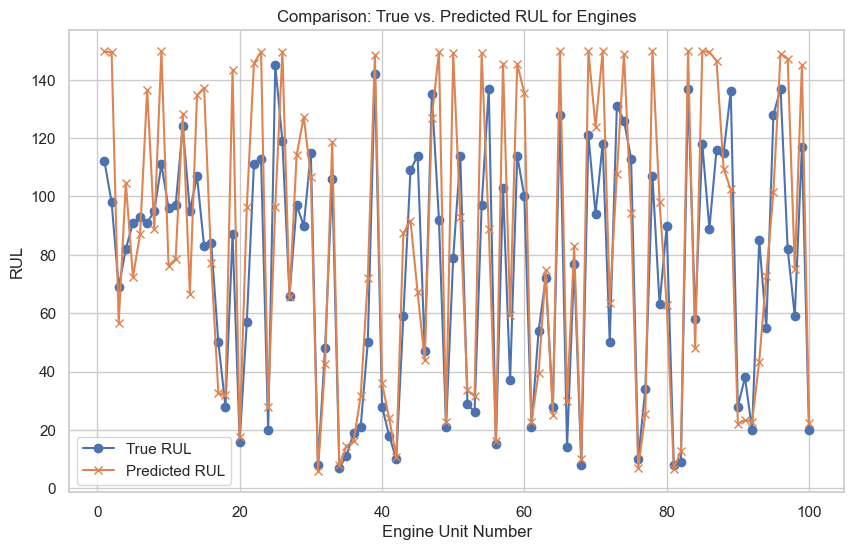

In [7]:
# Shows accuracy per engine on the test set.
plt.figure(figsize=(10, 6))
plt.plot(results_df['Unit'], results_df['True RUL'], marker='o', label='True RUL')
plt.plot(results_df['Unit'], results_df['Predicted RUL'], marker='x', label='Predicted RUL')
plt.xlabel('Engine Unit Number')
plt.ylabel('RUL')
plt.title("Comparison: True vs. Predicted RUL for Engines")
plt.legend()
plt.show()


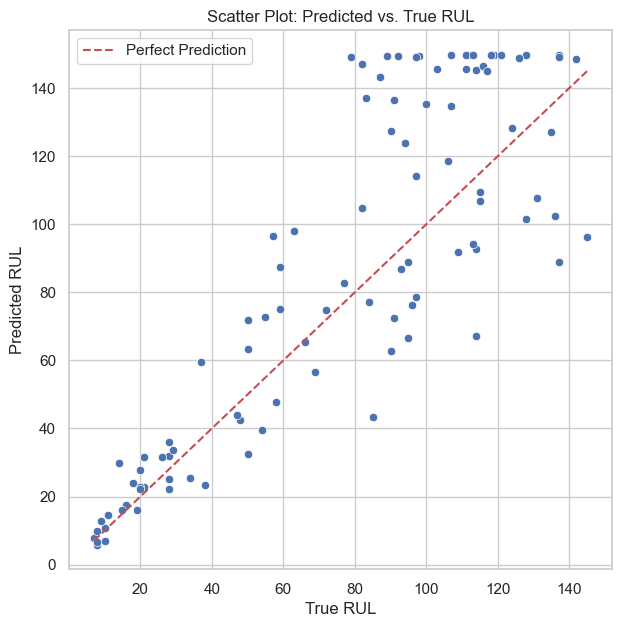

In [8]:
# Shows over/under-prediction bias, variance.
plt.figure(figsize=(7,7))
sns.scatterplot(
    x='True RUL', y='Predicted RUL', data=results_df)
plt.plot([results_df['True RUL'].min(), results_df['True RUL'].max()],
         [results_df['True RUL'].min(), results_df['True RUL'].max()],
         'r--', label='Perfect Prediction')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Scatter Plot: Predicted vs. True RUL')
plt.legend()
plt.show()


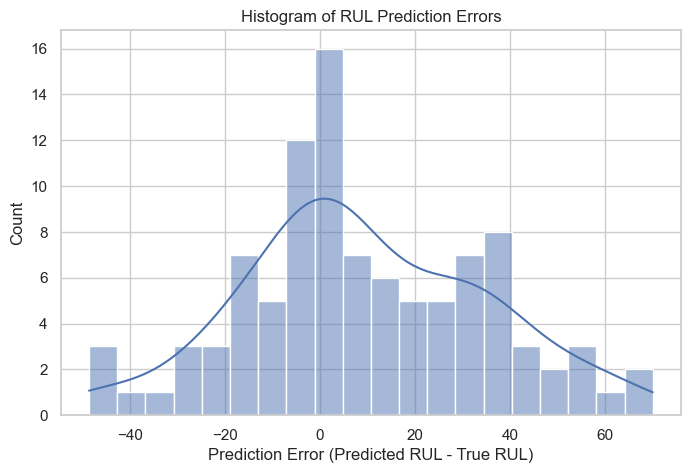

In [9]:
# Identifies if your model systematically over- or under-predicts.
errors = results_df['Predicted RUL'] - results_df['True RUL']
plt.figure(figsize=(8,5))
sns.histplot(errors, bins=20, kde=True)
plt.xlabel('Prediction Error (Predicted RUL - True RUL)')
plt.title("Histogram of RUL Prediction Errors")
plt.show()


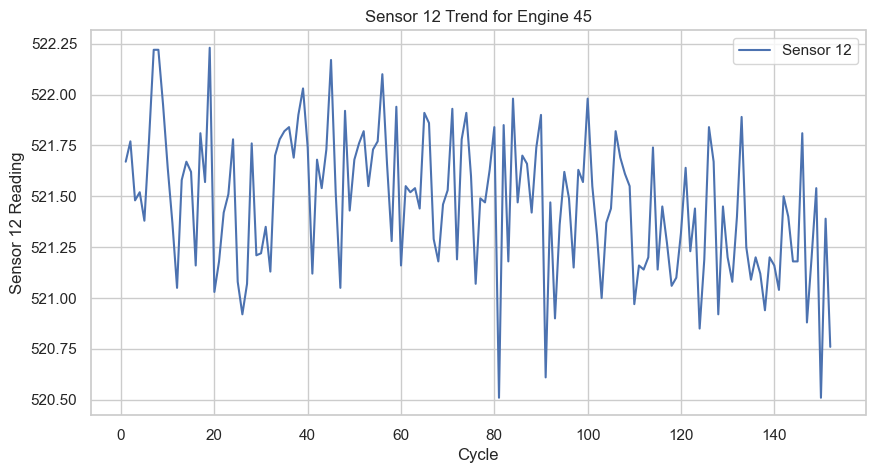

In [10]:
# Illustrates how input features evolve as RUL declines.
engine_id = test_df[test_df['unit'] == 45]['unit'].iloc[0]
unit_df = test_df[test_df['unit']==engine_id].sort_values("cycle")
plt.figure(figsize=(10,5))
plt.plot(unit_df['cycle'], unit_df['sensor_12'], label='Sensor 12')
plt.ylabel('Sensor 12 Reading')
plt.xlabel('Cycle')
plt.title(f'Sensor 12 Trend for Engine {engine_id}')
plt.legend()
plt.show()
